In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from data import data_preprocess
from evaluation import metrics
from model import end2end, end2end_crps

In [2]:
x_train, y_train, x_test, y_test = data_preprocess.data_preprocess('crimes')

In [3]:
end2end_model = end2end.train_model(x_train, y_train, n_epoch = 1000, num_models = 5, hidden_layers = [50, 50], learning_rate = 0.001, tanh = True, calibration_threshold = .03, exp_decay = .998)

initial loss:  -0.14182236790657043
502 0.05768311111111109 tensor(-5.1052, grad_fn=<MeanBackward0>) tensor(0.0442, grad_fn=<SumBackward1>)
504 0.06787733333333328 tensor(-5.0893, grad_fn=<MeanBackward0>) tensor(0.0452, grad_fn=<SumBackward1>)
505 0.034204000000000026 tensor(-5.0813, grad_fn=<MeanBackward0>) tensor(0.0417, grad_fn=<SumBackward1>)
506 0.07757022222222222 tensor(-5.0826, grad_fn=<MeanBackward0>) tensor(0.0462, grad_fn=<SumBackward1>)
507 0.03702888888888891 tensor(-5.0809, grad_fn=<MeanBackward0>) tensor(0.0419, grad_fn=<SumBackward1>)
508 0.07634266666666666 tensor(-5.0928, grad_fn=<MeanBackward0>) tensor(0.0459, grad_fn=<SumBackward1>)
509 0.0333626666666667 tensor(-5.0931, grad_fn=<MeanBackward0>) tensor(0.0416, grad_fn=<SumBackward1>)
510 0.07000222222222219 tensor(-5.1053, grad_fn=<MeanBackward0>) tensor(0.0453, grad_fn=<SumBackward1>)
512 0.06080399999999994 tensor(-5.1232, grad_fn=<MeanBackward0>) tensor(0.0444, grad_fn=<SumBackward1>)
514 0.060845333333333286 ten

798 0.04497599999999997 tensor(-5.5226, grad_fn=<MeanBackward0>) tensor(0.0432, grad_fn=<SumBackward1>)
800 0.044572888888888856 tensor(-5.5237, grad_fn=<MeanBackward0>) tensor(0.0432, grad_fn=<SumBackward1>)
802 0.04227999999999998 tensor(-5.5287, grad_fn=<MeanBackward0>) tensor(0.0430, grad_fn=<SumBackward1>)
804 0.04247777777777776 tensor(-5.5339, grad_fn=<MeanBackward0>) tensor(0.0430, grad_fn=<SumBackward1>)
806 0.042553333333333304 tensor(-5.5376, grad_fn=<MeanBackward0>) tensor(0.0430, grad_fn=<SumBackward1>)
808 0.043919111111111075 tensor(-5.5356, grad_fn=<MeanBackward0>) tensor(0.0432, grad_fn=<SumBackward1>)
810 0.04505955555555553 tensor(-5.5317, grad_fn=<MeanBackward0>) tensor(0.0433, grad_fn=<SumBackward1>)
812 0.04426177777777775 tensor(-5.5359, grad_fn=<MeanBackward0>) tensor(0.0431, grad_fn=<SumBackward1>)
814 0.04164088888888888 tensor(-5.5397, grad_fn=<MeanBackward0>) tensor(0.0429, grad_fn=<SumBackward1>)
816 0.03964399999999998 tensor(-5.5474, grad_fn=<MeanBackward

End2end test MAPE:  0.6313638


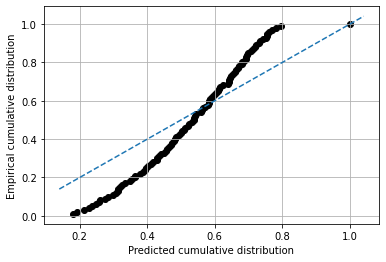

End2end test calibration error when step size is 0.001:  16.819254633839268
End2end test calibration error when step size is 0.01:  1.6589617525684124
End2end test calibration error when step size is 0.1:  0.13282362815728516


In [4]:
mean_pred, var_pred = end2end_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()

print('End2end test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('End2end test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('End2end test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('End2end test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

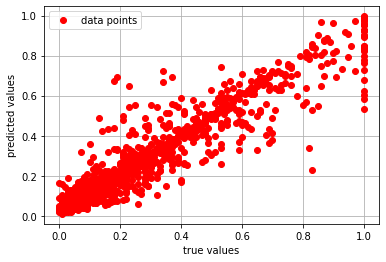

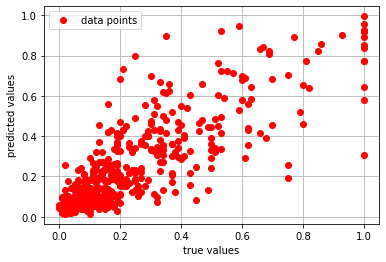

In [5]:
plt.plot(y_train.detach().numpy(), end2end_model(x_train)[0].detach().numpy().squeeze(1), 'or', label='data points')
plt.grid()
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.legend()
plt.show()

plt.plot(y_test.detach().numpy(), mean_pred.squeeze(1), 'or', label='data points')
plt.grid()
plt.xlabel('true values')
plt.ylabel('predicted values')
plt.legend()
plt.show()

In [3]:
end2end_model = end2end_crps.train_model(x_train, y_train, n_epoch = 1000, num_models = 5, hidden_layers = [50, 50], learning_rate = 0.001, tanh = True, calibration_threshold = .03, exp_decay = .998)

initial loss:  -0.12684239447116852
501 0.07288222222222221 tensor(-5.1233, grad_fn=<MeanBackward0>) tensor(0.0372, grad_fn=<MeanBackward0>)
503 0.06535422222222219 tensor(-5.1340, grad_fn=<MeanBackward0>) tensor(0.0370, grad_fn=<MeanBackward0>)
505 0.05922888888888885 tensor(-5.1480, grad_fn=<MeanBackward0>) tensor(0.0369, grad_fn=<MeanBackward0>)
507 0.05700133333333331 tensor(-5.1572, grad_fn=<MeanBackward0>) tensor(0.0368, grad_fn=<MeanBackward0>)
509 0.061367111111111074 tensor(-5.1552, grad_fn=<MeanBackward0>) tensor(0.0368, grad_fn=<MeanBackward0>)
511 0.06943999999999999 tensor(-5.1470, grad_fn=<MeanBackward0>) tensor(0.0368, grad_fn=<MeanBackward0>)
512 0.030355111111111135 tensor(-5.1441, grad_fn=<MeanBackward0>) tensor(0.0369, grad_fn=<MeanBackward0>)
513 0.07364799999999999 tensor(-5.1398, grad_fn=<MeanBackward0>) tensor(0.0368, grad_fn=<MeanBackward0>)
515 0.06271866666666666 tensor(-5.1624, grad_fn=<MeanBackward0>) tensor(0.0366, grad_fn=<MeanBackward0>)
517 0.05716622222

653 0.0503062222222222 tensor(-5.3736, grad_fn=<MeanBackward0>) tensor(0.0341, grad_fn=<MeanBackward0>)
655 0.043460888888888875 tensor(-5.3977, grad_fn=<MeanBackward0>) tensor(0.0340, grad_fn=<MeanBackward0>)
657 0.04317155555555555 tensor(-5.4067, grad_fn=<MeanBackward0>) tensor(0.0339, grad_fn=<MeanBackward0>)
659 0.04942088888888886 tensor(-5.3940, grad_fn=<MeanBackward0>) tensor(0.0340, grad_fn=<MeanBackward0>)
661 0.05879466666666664 tensor(-5.3749, grad_fn=<MeanBackward0>) tensor(0.0341, grad_fn=<MeanBackward0>)
663 0.05889377777777775 tensor(-5.3824, grad_fn=<MeanBackward0>) tensor(0.0339, grad_fn=<MeanBackward0>)
665 0.05133466666666663 tensor(-5.4046, grad_fn=<MeanBackward0>) tensor(0.0338, grad_fn=<MeanBackward0>)
667 0.048684888888888875 tensor(-5.4143, grad_fn=<MeanBackward0>) tensor(0.0337, grad_fn=<MeanBackward0>)
669 0.050982666666666634 tensor(-5.4111, grad_fn=<MeanBackward0>) tensor(0.0337, grad_fn=<MeanBackward0>)
671 0.05405288888888888 tensor(-5.4029, grad_fn=<Mean

805 0.04601822222222221 tensor(-5.5648, grad_fn=<MeanBackward0>) tensor(0.0322, grad_fn=<MeanBackward0>)
807 0.04388133333333333 tensor(-5.5768, grad_fn=<MeanBackward0>) tensor(0.0321, grad_fn=<MeanBackward0>)
809 0.03897911111111109 tensor(-5.5882, grad_fn=<MeanBackward0>) tensor(0.0321, grad_fn=<MeanBackward0>)
811 0.0393671111111111 tensor(-5.5888, grad_fn=<MeanBackward0>) tensor(0.0321, grad_fn=<MeanBackward0>)
813 0.04183599999999998 tensor(-5.5842, grad_fn=<MeanBackward0>) tensor(0.0321, grad_fn=<MeanBackward0>)
815 0.04357555555555553 tensor(-5.5833, grad_fn=<MeanBackward0>) tensor(0.0321, grad_fn=<MeanBackward0>)
817 0.041679999999999995 tensor(-5.5900, grad_fn=<MeanBackward0>) tensor(0.0321, grad_fn=<MeanBackward0>)
819 0.03969066666666665 tensor(-5.5973, grad_fn=<MeanBackward0>) tensor(0.0320, grad_fn=<MeanBackward0>)
821 0.04000622222222219 tensor(-5.5970, grad_fn=<MeanBackward0>) tensor(0.0320, grad_fn=<MeanBackward0>)
823 0.04189911111111108 tensor(-5.5940, grad_fn=<MeanBa

959 0.033856 tensor(-5.7334, grad_fn=<MeanBackward0>) tensor(0.0309, grad_fn=<MeanBackward0>)
961 0.03348666666666666 tensor(-5.7362, grad_fn=<MeanBackward0>) tensor(0.0309, grad_fn=<MeanBackward0>)
963 0.03363155555555555 tensor(-5.7340, grad_fn=<MeanBackward0>) tensor(0.0309, grad_fn=<MeanBackward0>)
965 0.034464444444444416 tensor(-5.7336, grad_fn=<MeanBackward0>) tensor(0.0309, grad_fn=<MeanBackward0>)
967 0.034568444444444416 tensor(-5.7371, grad_fn=<MeanBackward0>) tensor(0.0308, grad_fn=<MeanBackward0>)
969 0.0327631111111111 tensor(-5.7411, grad_fn=<MeanBackward0>) tensor(0.0308, grad_fn=<MeanBackward0>)
971 0.033859999999999994 tensor(-5.7426, grad_fn=<MeanBackward0>) tensor(0.0308, grad_fn=<MeanBackward0>)
973 0.03319644444444443 tensor(-5.7428, grad_fn=<MeanBackward0>) tensor(0.0308, grad_fn=<MeanBackward0>)
975 0.03429555555555556 tensor(-5.7435, grad_fn=<MeanBackward0>) tensor(0.0308, grad_fn=<MeanBackward0>)
977 0.03382844444444444 tensor(-5.7462, grad_fn=<MeanBackward0>)

End2end test MAPE:  0.67082226
End2end test RMSE:  0.14475171


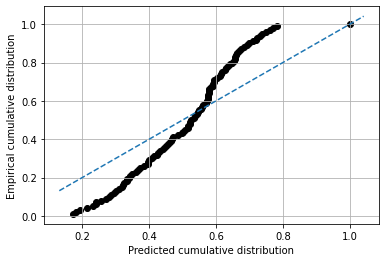

End2end test calibration error when step size is 0.001:  18.107481180749563
End2end test calibration error when step size is 0.01:  1.7848764446675365
End2end test calibration error when step size is 0.1:  0.14393908224267538


In [4]:
mean_pred, var_pred = end2end_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()

print('End2end test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('End2end test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('End2end test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('End2end test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('End2end test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))